## Given edit and corresponding logit bump, examine the differences

In [31]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from difflib import SequenceMatcher
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy import stats
import pandas as pd

In [2]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, list_to_dict, ensure_dir
from utils.model_utils import prepare_device, quick_predict
from utils.df_utils import load_and_preprocess_csv
from utils.visualizations import plot
from parse_config import ConfigParser
from data_loader import data_loaders
import model.model as module_arch

In [81]:
# Define constants, paths
class_list_path = os.path.join('metadata', 'cinic-10', 'class_names.txt')
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)

target_class_name = 'airplane'
target_class_idx = class_idx_dict[target_class_name]
n_select = 100

# Get paths to post edit trial paths
edit_trial_paths_path = 'saved/edit/trials/CINIC10_ImageNet-VGG_16/airplane_100/0214_112633/trial_paths.txt'
assert '{}_{}'.format(target_class_name, n_select) in edit_trial_paths_path
logit_bump_trial_paths_path = 'saved/edit/experiments/corresponding_bump_edits/CINIC10_ImageNet-VGG_16/0213_143741/airplane_100/trial_paths_med.txt'
assert '{}_{}'.format(target_class_name, n_select) in logit_bump_trial_paths_path
edit_trial_csv_path =  'saved/edit/trials/CINIC10_ImageNet-VGG_16/airplane_100/0214_112633/results_table.csv'

# Load trial paths
edit_trial_paths = read_lists(edit_trial_paths_path)
logit_bump_trial_paths = read_lists(logit_bump_trial_paths_path)

print("length of edit trial paths: {}".format(len(edit_trial_paths)))
print("length of logit bump trial paths: {}".format(len(logit_bump_trial_paths)))

# Load CSV from original results
edit_trial_df = load_and_preprocess_csv(
    csv_path=edit_trial_csv_path,
    drop_duplicates=['ID'],
    round_to=3)

length of edit trial paths: 158
length of logit bump trial paths: 158


In [82]:
# Load pre edit logits
pre_edit_logits_path = 'metadata/CINIC10_ImageNet-VGG_16/pre_edit_validation_set/pre_edit_logits.pth'
pre_edit_logits = torch.load(pre_edit_logits_path)
print("Loaded pre-edit logits from {}".format(pre_edit_logits_path))

# Load labels
val_labels_path = 'paths/datasets/cinic-10-imagenet/valid_labels.txt'
val_labels = np.array(read_lists(val_labels_path))
val_labels = val_labels.astype(float)
print("Loaded ground truth labels for validation set from {}".format(val_labels_path))

Loaded pre-edit logits from metadata/CINIC10_ImageNet-VGG_16/pre_edit_validation_set/pre_edit_logits.pth
Loaded ground truth labels for validation set from paths/datasets/cinic-10-imagenet/valid_labels.txt


### Define functions to 1) plot pre edit logits

In [83]:
def split_data_by_ground_truth(data,
                               ground_truths,
                               target_class_idx):
    '''
    Split data into two groups: those where ground_truths == target_class_idx and those where it doesn't
    
    Arg(s):
        data : N-dim np.array
            Data to partition
        ground_truths : N-dim np.array
            ground truth values of corresponding elements in data
        target_class_idx : int
            target value to split from others
    
    Returns:
        (np.array, np.array) : data array partitioned into two groups
    '''
    assert data.shape == ground_truths.shape
    inclusive_idxs = np.where(torch.from_numpy(ground_truths) == target_class_idx)
    exclusive_idxs = np.where(ground_truths != target_class_idx)
    
    inclusive_data = data[inclusive_idxs]
    exclusive_data = data[exclusive_idxs]
    
    return inclusive_data, exclusive_data

def plot_pre_post(pre_edit_logits,
                  post_edit_logits,
                  logit_bump_logits,
                  target_class_idx,
                  image_id,
                  ground_truth_labels=None,
                  subset='all',
                  n_classes=10,
                  plot_softmax=False,
                  show=True,
                  save_path=None):
    '''
    Plot graph of post edit vs pre edit logits/softmax for each data point in the validation set
    
    Arg(s):
        pre_edit_logits : N x C (70K x 10) torch.tensor
            logits of the pre edit model 
        post_edit_logits : N x C (70K x 10) torch.tensor
            logits of the post edit model 
        logit_bump_logits : N x C (70K x 10) torch.tensor
            logits of the corresponding logit_bump to the post edit model
        target_class_idx : int
            index of target class
        image_id : str
            image identifier string
        ground_truth_labels : N length np.array
            ground truth labels of validation set
        target_class_name : str
            name of target class
        plot_softmax : bool
            if True, plot the softmax instead of pure logits values
        show : bool
            whether or not to show graph
        save_path : str or None
            if not None, save plot to designated path
    '''

    # Obtain x, y of data points
    if plot_softmax:
        # Get softmax and convert back to numpy
        if not torch.is_tensor(pre_edit_logits):
            pre_edit_logits = torch.from_numpy(pre_edit_logits)
        if not torch.is_tensor(post_edit_logits):
            post_edit_logits = torch.from_numpy(post_edit_logits)
        if not torch.is_tensor(logit_bump_logits):
            logit_bump_logits = torch.from_numpy(logit_bump_logits)
        
        pre_edit_softmax = torch.softmax(pre_edit_logits, dim=1).cpu().numpy()
        post_edit_softmax = torch.softmax(post_edit_logits, dim=1).cpu().numpy()
        logit_bump_softmax = torch.softmax(logit_bump_logits, dim=1).cpu().numpy()
        
        pre_edit_target_data = pre_edit_softmax
        post_edit_target_data = post_edit_softmax
        logit_bump_target_data = logit_bump_softmax
        
        # xs = [pre_edit_target_softmax, pre_edit_target_softmax]
        # ys = [post_edit_target_softmax, logit_bump_target_softmax]
        # legends = ['Edited Softmax', 'Logit Bump Softmax']
        
    else:
        # Convert all to numpy
        if torch.is_tensor(pre_edit_logits):
            pre_edit_logits = pre_edit_logits.cpu().numpy()
        if torch.is_tensor(post_edit_logits):
            post_edit_logits = post_edit_logits.cpu().numpy()
        if torch.is_tensor(logit_bump_logits):
            logit_bump_logits = logit_bump_logits.cpu().numpy()
            
        pre_edit_target_data = pre_edit_logits
        post_edit_target_data = post_edit_logits
        logit_bump_target_data = logit_bump_logits
    
    # Get predictions
    post_edit_predictions = np.argmax(post_edit_target_data, axis=1)
    logit_bump_predictions = np.argmax(logit_bump_target_data, axis=1)
    # Choose appropriate subset of data
    if subset == 'all': # all data points
        pre_edit_target_data = pre_edit_target_data[:, target_class_idx]
        post_edit_target_data = post_edit_target_data[:, target_class_idx]
        logit_bump_target_data = logit_bump_target_data[:, target_class_idx]
    else:
        # post_edit_predictions = np.argmax(post_edit_target_data, axis=1)
        # logit_bump_predictions = np.argmax(logit_bump_target_data, axis=1)
        post_edit_subset_idxs = np.where(post_edit_predictions == target_class_idx) # where the max = target_class_idx
        logit_bump_subset_idxs = np.where(logit_bump_predictions == target_class_idx)
        overlap_subset_idxs = np.intersect1d(post_edit_subset_idxs, logit_bump_subset_idxs)
        if ground_truth_labels is not None:
            true_class_idxs = np.where(ground_truth_labels == target_class_idx)
        
        # Sanity check that these are corresponding
        assert abs(len(post_edit_subset_idxs) - len(logit_bump_subset_idxs)) < 10
        
        # Obtain slice of logits for target_class
        pre_edit_target_data = pre_edit_target_data[:, target_class_idx]
        post_edit_target_data = post_edit_target_data[:, target_class_idx]
        logit_bump_target_data = logit_bump_target_data[:, target_class_idx]
        
        if subset == 'pred_target': # data points where edited prediction is target
            
            pre_edit_target_data = pre_edit_target_data[post_edit_subset_idxs]

            # post_edit_target_data = post_edit_target_data[:, target_class_idx]
            post_edit_target_data = post_edit_target_data[post_edit_subset_idxs]

            # logit_bump_target_data = logit_bump_target_data[:, target_class_idx]
            logit_bump_target_data = logit_bump_target_data[post_edit_subset_idxs]
            post_edit_predictions = post_edit_predictions[post_edit_subset_idxs] 
            logit_bump_predictions = logit_bump_predictions[post_edit_subset_idxs] 
            if ground_truth_labels is not None:
                ground_truth_labels = ground_truth_labels[post_edit_subset_idxs]
            
        elif subset == 'logit_bump_target':  # data points where logit bump is target
            # pre_edit_target_data = pre_edit_target_data[:, target_class_idx]
            pre_edit_target_data = pre_edit_target_data[logit_bump_subset_idxs]

            # post_edit_target_data = post_edit_target_data[:, target_class_idx]
            post_edit_target_data = post_edit_target_data[logit_bump_subset_idxs]

            # logit_bump_target_data = logit_bump_target_data[:, target_class_idx]
            logit_bump_target_data = logit_bump_target_data[logit_bump_subset_idxs]
            post_edit_predictions = post_edit_predictions[logit_bump_subset_idxs] 
            logit_bump_predictions = logit_bump_predictions[logit_bump_subset_idxs] 
            if ground_truth_labels is not None:
                ground_truth_labels = ground_truth_labels[logit_bump_subset_idxs]
            
        elif subset == 'pred_logit_bump_target': # data where both edited and logit bump are target
            # pre_edit_target_data = pre_edit_target_data[:, target_class_idx]
            pre_edit_target_data = pre_edit_target_data[overlap_subset_idxs]

            # post_edit_target_data = post_edit_target_data[:, target_class_idx]
            post_edit_target_data = post_edit_target_data[overlap_subset_idxs]

            # logit_bump_target_data = logit_bump_target_data[:, target_class_idx]
            logit_bump_target_data = logit_bump_target_data[overlap_subset_idxs]
            post_edit_predictions = post_edit_predictions[overlap_subset_idxs] 
            logit_bump_predictions = logit_bump_predictions[overlap_subset_idxs] 
            if ground_truth_labels is not None:
                ground_truth_labels = ground_truth_labels[overlap_subset_idxs]
        elif subset == 'true_target': # data where the true class is target (has underlying assumptions about how data is ordered)
            assert ground_truth_labels is not None
            # true_class_idxs = np.where(ground_truth_labels == target_class_idx)
            # start_idx = target_class_idx * n_per_class
            pre_edit_target_data = pre_edit_target_data[true_class_idxs]
            post_edit_target_data = post_edit_target_data[true_class_idxs]
            logit_bump_target_data = logit_bump_target_data[true_class_idxs]
            post_edit_predictions = post_edit_predictions[true_class_idxs] 
            logit_bump_predictions = logit_bump_predictions[true_class_idxs] 
            ground_truth_labels = ground_truth_labels[true_class_idxs]
            
    # Partition data base on whether truly class or not
    if ground_truth_labels is not None:
        pre_edit_target_data_inclusive, pre_edit_target_data_exclusive = \
            split_data_by_ground_truth(
                data=pre_edit_target_data,
                ground_truths=ground_truth_labels,
                target_class_idx=target_class_idx)
        
        post_edit_target_data_inclusive, post_edit_target_data_exclusive = \
            split_data_by_ground_truth(
                data=post_edit_target_data,
                ground_truths=ground_truth_labels,
                target_class_idx=target_class_idx)
        
        logit_bump_target_data_inclusive, logit_bump_target_data_exclusive = \
            split_data_by_ground_truth(
                data=logit_bump_target_data,
                ground_truths=ground_truth_labels,
                target_class_idx=target_class_idx)
        xs = [
            pre_edit_target_data_exclusive,
            pre_edit_target_data_inclusive,
            pre_edit_target_data_exclusive,
            pre_edit_target_data_inclusive]
        ys = [
            post_edit_target_data_exclusive,
            post_edit_target_data_inclusive, 
            logit_bump_target_data_exclusive,
            logit_bump_target_data_inclusive]
        legends = [
            'Post Edit {} (not target_class)'.format('Softmax' if plot_softmax else 'Logits'),
            'Post Edit {} (target class)'.format('Softmax' if plot_softmax else 'Logits'),
            'Logit Bump {} (not target class)'.format('Softmax' if plot_softmax else 'Logits'),
            'Logit Bump {} (target class)'.format('Softmax' if plot_softmax else 'Logits'),
            
        ]
    else:
        xs = [pre_edit_target_data, pre_edit_target_data]
        ys = [post_edit_target_data, logit_bump_target_data]
        legends = [
            'Post Edit {}'.format('Softmax' if plot_softmax else 'Logits'), 
            'Logit Bump {}'.format('Softmax' if plot_softmax else 'Logits')
        ]

    if ground_truth_labels is not None:
    # Set labels and axes
    # Calculate precision (TP / (TP + FN)) for each group
        edit_TP = np.count_nonzero(np.logical_and(
            post_edit_predictions == target_class_idx,
            ground_truth_labels == target_class_idx))
        edit_TP_FP = np.count_nonzero(post_edit_predictions == target_class_idx)
        logit_bump_TP = np.count_nonzero(np.logical_and(
            logit_bump_predictions == target_class_idx,
            ground_truth_labels == target_class_idx))
        logit_bump_TP_FP = np.count_nonzero(logit_bump_predictions == target_class_idx)
        print(edit_TP)
        edit_precision = round(100 * edit_TP / edit_TP_FP, 2)
        logit_bump_precision = round(100 * logit_bump_TP / logit_bump_TP_FP, 2)
        title = 'Pre vs Post Edit {} for \n{}\nSubset: {}\nEdit Precision: {}\nLogit Bump Precision: {}'.format(
            'Softmax' if plot_softmax else 'Logits',
            image_id,
            subset,
            edit_precision,
            logit_bump_precision)
        
    else:
        title = 'Pre vs Post Edit {} for \n{}\nSubset: {}'.format(
            'Softmax' if plot_softmax else 'Logits',
            image_id,
            subset)
    xlabel = 'Pre Edit {}'.format('Softmax' if plot_softmax else 'Logits')
    ylabel = 'Post Edit {}'.format('Softmax' if plot_softmax else 'Logits')
        
    # Endpoints of the y=x line
    if plot_softmax:
        highlight = None
        highlight_label = None
    else:
        pre_edit_data_min = np.amin(pre_edit_target_data)
        pre_edit_data_max = np.amax(pre_edit_target_data)
        highlight = [(pre_edit_data_min, pre_edit_data_max), (pre_edit_data_min, pre_edit_data_max)]
        highlight_label = 'y=x'
        
    fig, axs = plot(
        xs=xs,
        ys=ys,
        labels=legends,
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        highlight=highlight,
        highlight_label=highlight_label,
        alpha=0.2,
        marker_size=2,
        scatter=True,
        line=False,
        show=show,
        save_path=save_path)
    

    return fig, axs


### Graph the pre vs post edit logits for edit trials and corresponding logit bump on same axes

6587


<Figure size 640x480 with 0 Axes>

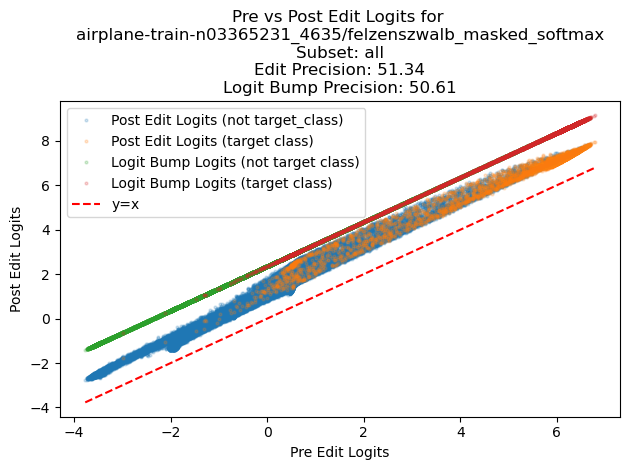

6587


<Figure size 640x480 with 0 Axes>

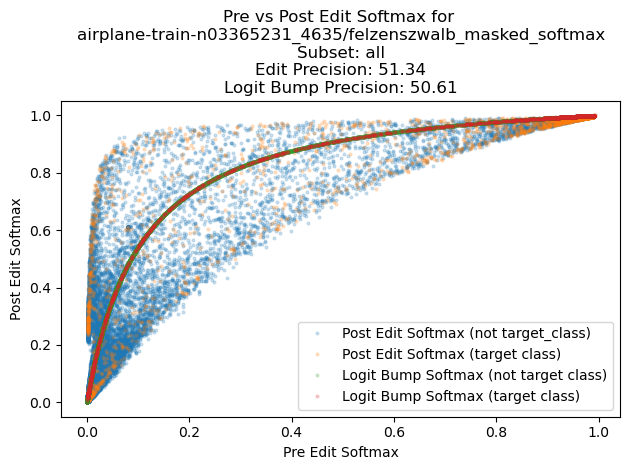

6966


<Figure size 640x480 with 0 Axes>

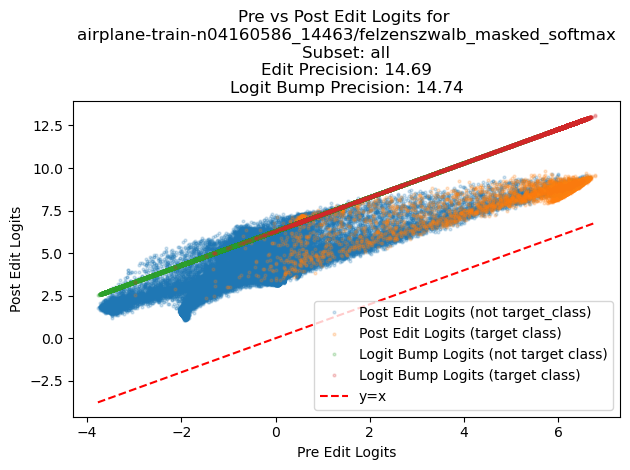

6966


<Figure size 640x480 with 0 Axes>

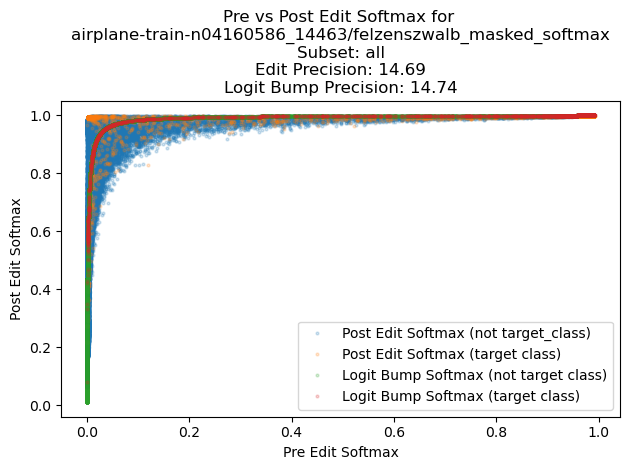

6659


<Figure size 640x480 with 0 Axes>

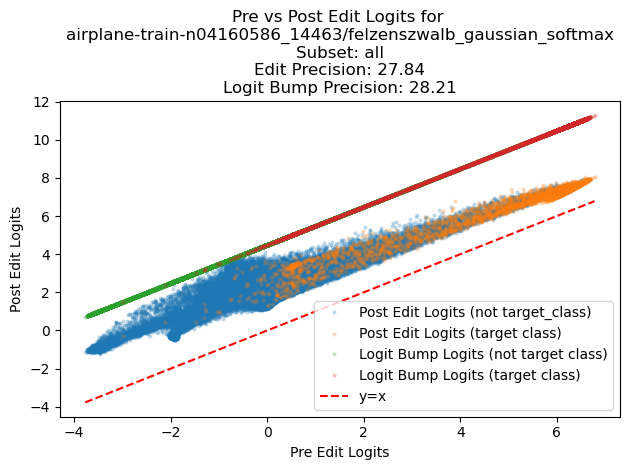

6659


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

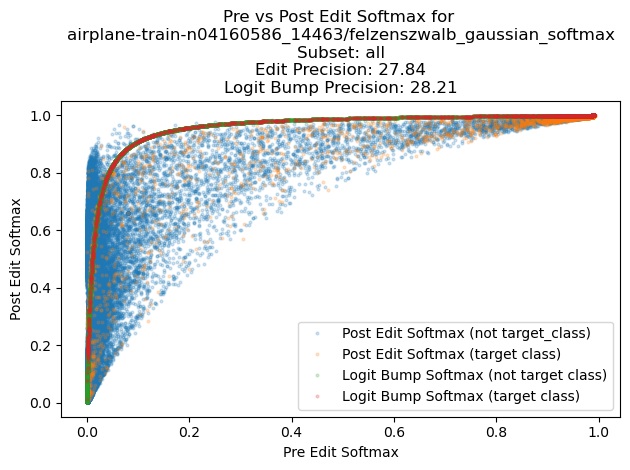

In [84]:
# n_data_points = 7000
# Create directory to save graphs
save_root = os.path.dirname(logit_bump_trial_paths_path)

# Define possible subset of data points to look at
subset = 'pred_logit_bump_target' # ['all', 'pred_target', 'logit_bump_target', 'pred_logit_bump_target', 'true_target']
subsets = ['all', 'pred_target', 'logit_bump_target', 'pred_logit_bump_target', 'true_target']
show = True
save_graphs_dir = os.path.join(save_root, 'graphs', 'pre_post_logits')
trial_paths_path = os.path.join(save_root, 'trial_paths.txt')

for subset in subsets:
    for trial_idx, (edit_trial_path, logit_bump_trial_path) in enumerate(zip(edit_trial_paths, logit_bump_trial_paths)):
        if trial_idx == 10:
            break
        # Extract image_id
        image_id = edit_trial_path.split('results/')[-1]
        assert image_id in logit_bump_trial_path
        # s = SequenceMatcher(None, edit_trial_path, logit_bump_trial_path)
        # match = s.find_longest_match(alo=0, ahi=len(edit_trial_path), blo=0, bhi=len(logit_bump_trial_path))
        # image_id = edit_trial_path[match.a+1:match.a+match.size-len('_softmax')]
        # assert len(image_id) > 1
        # Create directory for this trial
        trial_dir = os.path.join(save_graphs_dir, image_id)

        edit_trial_logits_path = os.path.join(edit_trial_path, 'models', 'post_edit_logits.pth')
        logit_bump_logits_path = os.path.join(logit_bump_trial_path, 'models', 'post_edit_logits.pth')


        edit_trial_logits = torch.load(edit_trial_logits_path)
        logit_bump_logits = torch.load(logit_bump_logits_path)
        plot_pre_edit_logits = pre_edit_logits

        save_logits_path = os.path.join(
            trial_dir,
            '{}_pre_post_logits.png'.format(subset))
        save_softmax_path = os.path.join(
            trial_dir,
            '{}_pre_post_softmax.png'.format(subset))
        ensure_dir(os.path.dirname(save_softmax_path))

        logits_fig, logits_axis = plot_pre_post(
            pre_edit_logits=plot_pre_edit_logits,
            post_edit_logits=edit_trial_logits,
            logit_bump_logits=logit_bump_logits,
            target_class_idx=target_class_idx,
            image_id=image_id,
            ground_truth_labels=val_labels,
            subset=subset,
            show=show,
            save_path=save_logits_path)

        softmax_fig, softmax_axis = plot_pre_post(
            pre_edit_logits=plot_pre_edit_logits,
            post_edit_logits=edit_trial_logits,
            logit_bump_logits=logit_bump_logits,
            target_class_idx=target_class_idx,
            image_id=image_id,
            ground_truth_labels=val_labels,
            plot_softmax=True,
            subset=subset,
            show=show,
            save_path=save_softmax_path)
    

### Calculate IOU and spearman correlation between predictions for edit and logit bumping

In [106]:
def get_IOU(logits_a, 
            logits_b, 
            target_class_idx, 
            modes=['binary']):
    
    IOUs = []
    
    if torch.is_tensor(logits_a):
        logits_a = logits_a.cpu().numpy()
    if torch.is_tensor(logits_b):
        logits_b = logits_b.cpu().numpy()
    
    predictions_a = np.argmax(logits_a, axis=1)
    predictions_b = np.argmax(logits_b, axis=1)
    

    
    for mode in modes:
        try:
            if mode == 'binary':
                # Binarize predictions based on target class
                binary_predictions_a = np.where(
                    predictions_a == target_class_idx,
                    1, 0)
                binary_predictions_b = np.where(
                    predictions_b == target_class_idx,
                    1, 0)
                
                IOU = metrics.jaccard_score(
                    y_true=binary_predictions_a,
                    y_pred=binary_predictions_b,
                    average=mode)
            else:
                IOU = metrics.jaccard_score(
                    y_true=predictions_a,
                    y_pred=predictions_b,
                    average=mode)
            IOUs.append(IOU)
        except Exception as e:
            print(e)
            continue
    return IOUs
    
def get_ranking(logits, target_class_idx):
    if not torch.is_tensor(logits):
        logits = torch.from_numpy(logits)
    
    softmax = torch.softmax(logits, dim=1)
    target_softmax = softmax[:, target_class_idx]
    ranking = target_softmax.argsort().argsort()
    
    return ranking

def get_spearman(logits_a, logits_b, target_class_idx):
    ranking_a = get_ranking(
        logits=logits_a,
        target_class_idx=target_class_idx)
    ranking_b = get_ranking(
        logits=logits_b,
        target_class_idx=target_class_idx)
    
    if torch.is_tensor(ranking_a):
        ranking_a = ranking_a.cpu().numpy()
    if torch.is_tensor(ranking_b):
        ranking_b = ranking_b.cpu().numpy()
    spearman = stats.spearmanr(
        a=ranking_a,
        b=ranking_b)
    
    return spearman

In [111]:
# Data structures
stored_data = []
IOU_modes = ['binary', 'micro', 'weighted']

# Make local copy of edit trials' data frame
df = edit_trial_df.copy()
column_names = ['{} IOU'.format(mode) for mode in IOU_modes] + ['Spearman']

for trial_idx, (edit_trial_path, logit_bump_trial_path) in enumerate(tqdm(zip(edit_trial_paths, logit_bump_trial_paths))):
    # if trial_idx == 10:
    #     break
    
    # Extract image_id
    image_id = edit_trial_path.split('results/')[-1]
    assert image_id in logit_bump_trial_path
    
    assert len(image_id) > 1
    assert image_id in edit_trial_df['ID'].iloc[trial_idx]
    # sort_metric_value = edit_trial_df[sort_metric].iloc[trial_idx]
    
    # Create directory for this trial
    trial_dir = os.path.join(save_graphs_dir, image_id)
    
    # Load edited and logit bump logits
    edit_trial_logits_path = os.path.join(edit_trial_path, 'models', 'post_edit_logits.pth')
    logit_bump_logits_path = os.path.join(logit_bump_trial_path, 'models', 'post_edit_logits.pth')
    edit_trial_logits = torch.load(edit_trial_logits_path)
    logit_bump_logits = torch.load(logit_bump_logits_path)
    
    # Calculate IOUs
    IOUs = get_IOU(
        logits_a=edit_trial_logits,
        logits_b=logit_bump_logits,
        target_class_idx=target_class_idx,
        modes=IOU_modes)
    
    # Calculate Spearman Correlation
    spearman = get_spearman(
        logits_a=edit_trial_logits,
        logits_b=logit_bump_logits,
        target_class_idx=target_class_idx)
    
    stored_data.append(IOUs + [spearman.correlation])
    # binary_IOUs.append(IOUs[0])
    # macro_IOUs.append(IOUs[1])
    
# df['Binary IOU'] = binary_IOUs
# df['Macro IOU'] = macro_IOUs
    
# df = pd.DataFrame(stored_data, columns = ['Binary IOU', 'Macro IOU', 'Spearman'])
# Add columns to data frame

stored_data = np.array(stored_data)
assert len(column_names) == stored_data.shape[1]
for idx, column_name in enumerate(column_names):
    df[column_name] = stored_data[:, idx]

158it [00:22,  7.02it/s]


In [ ]:
# column_names = ['Binary IOU', 'Macro IOU', 'Spearman']
# stored_data = np.array(stored_data)
# for idx, column_name in enumerate(column_names):
#     df[column_name] = stored_data[:, idx]
#     print(df[column_name])

Pre Target Accuracy


<Figure size 640x480 with 0 Axes>

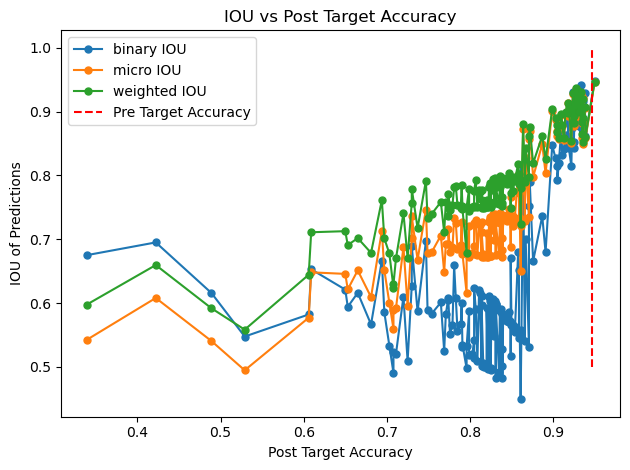

<Figure size 640x480 with 0 Axes>

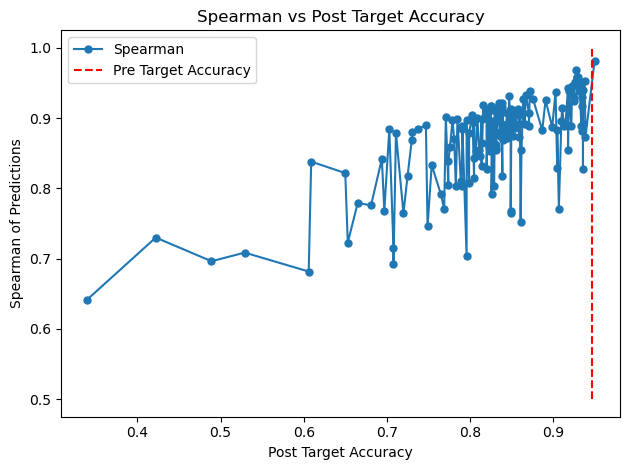

airplane-train-n02704645_17657/felzenszwalb_gaussian_softmax


In [127]:
sort_metric = 'Post Target Accuracy' # 'Post Mean Recall'#'Post Target Accuracy'
# sort_metric_values = edit_trial_df[sort_metric].to_numpy()
# df[sort_metric] = sort_metric_values
pre_edit_value = df[sort_metric.replace('Post', 'Pre')].to_numpy()[0]
assert np.abs(pre_edit_value - np.mean(pre_edit_value)) < 1e-5
sorted_df = df.sort_values(sort_metric.format('Post'))

# Plot IOUs
# plot(
#     xs=[sorted_df[sort_metric].to_numpy(), sorted_df[sort_metric].to_numpy()],
#     ys=[sorted_df['Binary IOU'].to_numpy(), sorted_df['Macro IOU'].to_numpy()],
#     labels=['Binary IOU', 'Macro IOU'],
#     marker_size=5,
#     title='IOU vs {}'.format(sort_metric),
#     xlabel=sort_metric,
#     ylabel='IOU of Predictions',
#     show=True)

# set xs, ys, and labels for IOUs
IOU_column_names = column_names[:-1]
x = sorted_df[sort_metric].to_numpy()
xs = [x for i in range(len(IOU_modes))]
ys = [sorted_df[col_name] for col_name in IOU_column_names]
labels = IOU_column_names
print(sort_metric.replace('Post', 'Pre'),)
plot(
    xs=xs,
    ys=ys,
    labels=labels,
    marker_size=5,
    title='IOU vs {}'.format(sort_metric),
    xlabel=sort_metric,
    ylabel='IOU of Predictions',
    highlight=[(pre_edit_value, pre_edit_value), (0.5, 1)],
    highlight_label=sort_metric.replace('Post', 'Pre'),
    show=True)

# Plot Spearman Coefficients
xs = [x]
ys = [sorted_df['Spearman'].to_numpy()]
labels = ['Spearman']
plot(
    xs=[sorted_df[sort_metric].to_numpy()],
    ys=ys,
    labels=labels,
    marker_size=5,
    title='Spearman vs {}'.format(sort_metric),
    xlabel=sort_metric,
    ylabel='Spearman of Predictions',
    highlight=[(pre_edit_value, pre_edit_value), (0.5, 1)],
    highlight_label=sort_metric.replace('Post', 'Pre'),
    show=True)

print(sorted_df['ID'].iloc[-1])

### Calculate Spearman correlation index

In [46]:
# if torch.is_tensor(pre_edit_logits):
#     pre_edit_logits = pre_edit_logits.cpu().numpy()

def get_ranking(logits, target_class_idx):
    if not torch.is_tensor(logits):
        logits = torch.from_numpy(logits)
    
    softmax = torch.softmax(logits, dim=1)
    target_softmax = softmax[:, target_class_idx]
    ranking = target_softmax.argsort().argsort()
    
    return ranking

def get_spearman(logits_a, logits_b, target_class_idx):
    ranking_a = get_ranking(
        logits=logits_a,
        target_class_idx=target_class_idx)
    ranking_b = get_ranking(
        logits=logits_b,
        target_class_idx=target_class_idx)
    
    spearman = stats.spearmanr(
        a=ranking_a,
        b=ranking_b)
    
    return spearman

for trial_idx, (edit_trial_path, logit_bump_trial_path) in enumerate(zip(edit_trial_paths, logit_bump_trial_paths)):
    if trial_idx == 10:
        break
    
    # Extract image_id
    image_id = edit_trial_path.split('results/')[-1]
    assert image_id in logit_bump_trial_path
    
    assert len(image_id) > 1
    assert image_id in edit_trial_df['ID'].iloc[trial_idx]
    sort_metric_value = edit_trial_df[sort_metric].iloc[trial_idx]
    
    # Create directory for this trial
    trial_dir = os.path.join(save_graphs_dir, image_id)
    
    # Load edited and logit bump logits
    edit_trial_logits_path = os.path.join(edit_trial_path, 'models', 'post_edit_logits.pth')
    logit_bump_logits_path = os.path.join(logit_bump_trial_path, 'models', 'post_edit_logits.pth')
    edit_trial_logits = torch.load(edit_trial_logits_path)
    logit_bump_logits = torch.load(logit_bump_logits_path)
    
    
    pre_edit_ranking = get_ranking(
        logits=pre_edit_logits,
        target_class_idx=target_class_idx).cpu().numpy()
    edit_trial_ranking = get_ranking(
        logits=edit_trial_logits,
        target_class_idx=target_class_idx).cpu().numpy()
    logit_bump_ranking = get_ranking(
        logits=logit_bump_logits,
        target_class_idx=target_class_idx).cpu().numpy()
    
    logit_bump_spearman = stats.spearmanr(
        a=pre_edit_ranking,
        b=logit_bump_ranking)
    
    edit_trial_spearman = stats.spearmanr(
        a=pre_edit_ranking,
        b=edit_trial_ranking)
    
    edit_trial_spearman2 = stats.spearmanr(
        a=logit_bump_ranking,
        b=edit_trial_ranking)
    print(pre_logit_bump_spearman)
    print(edit_trial_spearman)
    print(edit_trial_spearman2)
    print("")



print(pre_edit_ranking[:10])
print(logit_bump_ranking[:10])

SpearmanrResult(correlation=0.9999999997541921, pvalue=0.0)
SpearmanrResult(correlation=0.883786103845344, pvalue=0.0)
SpearmanrResult(correlation=0.8837861075616005, pvalue=0.0)

SpearmanrResult(correlation=0.9999999997541921, pvalue=0.0)
SpearmanrResult(correlation=0.7300190177953974, pvalue=0.0)
SpearmanrResult(correlation=0.730018446298371, pvalue=0.0)

SpearmanrResult(correlation=0.9999999997541921, pvalue=0.0)
SpearmanrResult(correlation=0.7464511513083602, pvalue=0.0)
SpearmanrResult(correlation=0.7464511118013514, pvalue=0.0)

SpearmanrResult(correlation=0.9999999997541921, pvalue=0.0)
SpearmanrResult(correlation=0.8918820170930953, pvalue=0.0)
SpearmanrResult(correlation=0.8918820042735967, pvalue=0.0)

SpearmanrResult(correlation=0.9999999997541921, pvalue=0.0)
SpearmanrResult(correlation=0.8590509201103601, pvalue=0.0)
SpearmanrResult(correlation=0.8590509062557827, pvalue=0.0)

SpearmanrResult(correlation=0.9999999997541921, pvalue=0.0)
SpearmanrResult(correlation=0.8885575